**UNR - TUIA**

# Trabajo Prático N°: 2 - Aprendizaje Automático

### Integrantes:
*   Crenna, Giuliano. Legajo: C-7438/1.
*   Pace, Bruno. Legajo: P-5295/7.
*   Sancho Almenar, Mariano. Legajo: S-5778/9.

In [105]:
#Tratamiento de datos:
import numpy as np
import pandas as pd
import math

#Gráficos:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Preprocesado y modelado:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, SGDRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
import random

from typing import Dict, List, Tuple

#Configuración de warnings:
import warnings
warnings.filterwarnings('ignore')


## Lectura, selección de ciudades y analisis de variables

In [57]:
df: pd.DataFrame = pd.read_csv('weatherAUS.csv')

Se seleccionan 10 ciudades aleatorias de dataset para analizar

In [58]:
random.seed(42)
choosen_cities =  random.sample(df['Location'].unique().tolist(), k=10)

In [59]:
# Se guarda en el DataFrame las tuplas con las ciudades elegidas
df: pd.DataFrame = df[df['Location'].isin(choosen_cities)].reset_index(drop = True) 


### Tipo de dato de las variables

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30818 entries, 0 to 30817
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           30818 non-null  object 
 1   Location       30818 non-null  object 
 2   MinTemp        30254 non-null  float64
 3   MaxTemp        30421 non-null  float64
 4   Rainfall       30243 non-null  float64
 5   Evaporation    10686 non-null  float64
 6   Sunshine       10127 non-null  float64
 7   WindGustDir    26779 non-null  object 
 8   WindGustSpeed  26797 non-null  float64
 9   WindDir9am     27071 non-null  object 
 10  WindDir3pm     28746 non-null  object 
 11  WindSpeed9am   29921 non-null  float64
 12  WindSpeed3pm   29269 non-null  float64
 13  Humidity9am    29837 non-null  float64
 14  Humidity3pm    29348 non-null  float64
 15  Pressure9am    21206 non-null  float64
 16  Pressure3pm    21250 non-null  float64
 17  Cloud9am       15523 non-null  float64
 18  Cloud3

In [61]:
df[['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',  'RainToday', 'RainTomorrow']].sample(2)

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
13947,2014-04-30,Penrith,SW,S,SSW,NaN,No
8095,2014-11-12,NorahHead,NNE,SSW,E,No,No


Se observa la presencia de ocho columnas categóricas, su análisis y procesamiento a continuacion.


### Date

Dado que 'Date' se encuentra con formato 'YYYY-MM-DD', se dividirá en 2 columnas distintas.

- **Year**: Será una variable categórica indicando el año, luego se codificará utilizando One-Hot Encoder.
- **Season**:  Indicará en qué temporada del año ocurrió la medición.

In [62]:
# OPCION 2
"""
Juntar mes y dia para que sea una columna numerica de 0 a 365, 
así hay un menor salto entre estaciones del año
el unico problema -> el salto de fin/comienzo de año

ANALIZAR HACER PROYECCIONES X E Y 
para mi (Mariano) probar este metodo, si sobra tiempo lo hacemos
""" 


df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

df['Day'] = df['Date'].dt.dayofyear

In [63]:
df[['Date', 'Year', 'Day']].sample(2)

,Date,Year,Day
16850,2013-12-14,2013,348
17069,2014-07-21,2014,202


In [64]:
df.drop(columns= 'Date', inplace=True)

In [65]:
# Cambiamos el formato de 'Date' a datetime de pandas para su manejo
# df['Date'] = pd.to_datetime(df['Date'])
# df['Year'] = df['Date'].dt.year

# Función para determinar la estación
def get_season(date):
    Y = date.year
    if pd.Timestamp(f'{Y}-12-1') <= date or date < pd.Timestamp(f'{Y}-03-01'):
        return 'Verano'
    elif pd.Timestamp(f'{Y}-03-01') <= date < pd.Timestamp(f'{Y}-06-01'):
        return 'Otoño'
    elif pd.Timestamp(f'{Y}-06-01') <= date < pd.Timestamp(f'{Y}-09-01'):
        return 'Invierno'
    else:
        return 'Primavera'


# df['Season'] = df['Date'].apply(get_season)

# df.drop(columns='Date', inplace=True)


### Mediciones del viento

Las columnas *WindGustDir*, *WindDir9am*, *WindDir3pm*, *WindSpeed3pm* indican la dirección del viento utilizando las direcciones cardinales.

Se transformarán dichas direcciones en las proyecciones que tienen sobre los ejes x e y.

In [66]:
def angle_to_xy(angle):
    """
    Función que recibe la dirección del viento en grados y la transformará en projecciones sobre el eje x e y, 
    obteniendo así dos valores numéricos por cada columna.
    """

    if math.isnan(angle):
        return (np.nan, np.nan)

    # Convertimos el ángulo a radianes
    angle_rad = math.radians(angle)


    x = math.sin(angle_rad)
    y = math.cos(angle_rad)

    return (x, y)

In [67]:
direction_angles = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
}

columnas_viento = ['WindDir3pm','WindDir9am', 'WindGustDir']

for columna in columnas_viento:
    
    df[columna] = df[columna].map(direction_angles)

# Creamos las columnas con las projecciones x e y para los distintos vientos.
df[['WindDir3pm_x', 'WindDir3pm_y']] = df['WindDir3pm'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

df[['WindDir9am_x', 'WindDir9am_y']] = df['WindDir9am'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

df[['WindGustDir_x', 'WindGustDir_y']] = df['WindGustDir'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

In [68]:
df.drop(columns= columnas_viento , inplace=True)


### Columnas categóricas Yes/No

Se remplazan por valores 1 y 0 

In [69]:
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [70]:
# df[['Year', 'Season', 'Location', 'WindDir3pm_x', 'WindDir3pm_y', 'WindDir9am_x', 'WindDir9am_y','WindGustDir_x', 'WindGustDir_y' ,  'RainToday', 'RainTomorrow']].sample(2)

df[['Year', 'Day', 'Location', 'WindDir3pm_x', 'WindDir3pm_y', 'WindDir9am_x', 'WindDir9am_y','WindGustDir_x', 'WindGustDir_y' ,  'RainToday', 'RainTomorrow']].sample(3)

,Year,Day,Location,WindDir3pm_x,WindDir3pm_y,WindDir9am_x,WindDir9am_y,WindGustDir_x,WindGustDir_y,RainToday,RainTomorrow
6906,2011,159,NorahHead,NaN,NaN,-0.923880,0.382683,NaN,NaN,0.0,NaN
24766,2009,151,Nuriootpa,1.000000,6.123234e-17,0.923880,-0.382683,0.923880,-0.382683,0.0,0.0
18338,2008,138,Canberra,-0.707107,7.071068e-01,-0.382683,0.923880,-0.707107,0.707107,0.0,0.0


### Location

Para la localidad, se remplaza su valor con su respectiva coordenada


In [71]:
chosen_cities_coordinates: Dict [str, Dict[str, float]] = {
    "Newcastle": {"latitude": -32.9282, "longitude": 151.7817},
    "BadgerysCreek": {"latitude": -33.8836, "longitude": 150.7386},
    "Penrith": {"latitude": -33.7532, "longitude": 150.6880},
    "Perth": {"latitude": -31.9505, "longitude": 115.8605},
    "Canberra": {"latitude": -35.2809, "longitude": 149.1300},
    "Wollongong": {"latitude": -34.4278, "longitude": 150.8931},
    "Nuriootpa": {"latitude": -34.4658, "longitude": 138.9784},
    "NorahHead": {"latitude": -33.2886, "longitude": 151.6154},
    "NorfolkIsland": {"latitude": -29.0408, "longitude": 167.9547},
    "MountGinini": {"latitude": -35.4622, "longitude": 148.9525}
}


In [72]:
coords_df: pd.DataFrame = pd.DataFrame.from_dict(chosen_cities_coordinates, orient='index') 
coords_df.reset_index(inplace=True) 
coords_df.rename(columns={'index':'Location'}, inplace=True) 
coords_df


,Location,latitude,longitude
0,Newcastle,-32.9282,151.7817
1,BadgerysCreek,-33.8836,150.7386
2,Penrith,-33.7532,150.6880
3,Perth,-31.9505,115.8605
4,Canberra,-35.2809,149.1300
5,Wollongong,-34.4278,150.8931
6,Nuriootpa,-34.4658,138.9784
7,NorahHead,-33.2886,151.6154
8,NorfolkIsland,-29.0408,167.9547
9,MountGinini,-35.4622,148.9525


In [73]:
df: pd.DataFrame = df.merge(coords_df, on='Location', how='left')
df: pd.DataFrame = df.drop(columns=['Location'])


## Division del conjunto

In [74]:
X: pd.DataFrame = df.drop(columns='RainTomorrow')
y: pd.DataFrame = df[['RainTomorrow']] #Variable a predecir

Separación test y train conforme a las convenciones del 80% para Train y 20% para test.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


## Manejo de variables categóricas
Usaremos one-hot encoding para el manejo de la columna *Year*.

In [76]:
#columnas_categoricas: List[str] = ['Year', 'Season']
columnas_categoricas: List[str] = ['Year']

encoder: OneHotEncoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')

In [77]:
X_train_enc = encoder.fit_transform(X_train[columnas_categoricas])
X_test_enc = encoder.transform(X_test[columnas_categoricas])

In [78]:
X_train = pd.concat([X_train, X_train_enc], axis=1)
X_test = pd.concat([X_test, X_test_enc], axis=1)

In [79]:
X_train.drop(columns=columnas_categoricas, inplace=True)
X_test.drop(columns=columnas_categoricas, inplace=True)

In [80]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24654 entries, 2194 to 23654
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        24206 non-null  float64
 1   MaxTemp        24363 non-null  float64
 2   Rainfall       24203 non-null  float64
 3   Evaporation    8560 non-null   float64
 4   Sunshine       8124 non-null   float64
 5   WindGustSpeed  21457 non-null  float64
 6   WindSpeed9am   23961 non-null  float64
 7   WindSpeed3pm   23442 non-null  float64
 8   Humidity9am    23876 non-null  float64
 9   Humidity3pm    23487 non-null  float64
 10  Pressure9am    17026 non-null  float64
 11  Pressure3pm    17062 non-null  float64
 12  Cloud9am       12440 non-null  float64
 13  Cloud3pm       11253 non-null  float64
 14  Temp9am        23997 non-null  float64
 15  Temp3pm        23570 non-null  float64
 16  RainToday      24203 non-null  float64
 17  Day            24654 non-null  int32  
 18  WindDir3


## Manejo de valores faltantes

Se utiliza KNN Imputer para imputar los valores faltantes.

In [81]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24654 entries, 2194 to 23654
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RainTomorrow  24203 non-null  float64
dtypes: float64(1)
memory usage: 385.2 KB


In [82]:
y_train.isna().sum()

RainTomorrow    451
dtype: int64

Se observa que y_train tiene 24654 datos, de los cuales 451 son datos faltantes. 

Esto representa aproximadamente 1.8% del dataset. Por eso se decide dropearlos.

In [83]:
#reseto indice para no tener problema
X_train.reset_index(inplace=True)
y_train.reset_index(inplace=True)

#almaceno los indices que no son na
indices_validos = y_train.dropna().index

Filtro los mismos indices válidos en ambos df de Train

In [84]:
y_train = y_train.iloc[indices_validos]
X_train = X_train.iloc[indices_validos]

In [85]:
y_train.isna().sum()

index           0
RainTomorrow    0
dtype: int64

Análisis duplicados en X_train. No se realiza con y_train ya que son 0 y 1 y daría duplicados.

In [86]:
X_train.duplicated().sum()

np.int64(0)

In [87]:
#Eliminación de columnas indices
X_train = X_train.drop(columns=['index'])
y_train = y_train.drop(columns=['index'])

In [88]:
knn = KNNImputer(n_neighbors=5)

X_train = pd.DataFrame(knn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns)


## Visulizaciones de distribuciones

In [89]:
columns: list[str] = X_train.columns.tolist()

In [90]:
columns_sin_anios: list[str] = []

for col in columns:
    if 'Year' not in col:
        columns_sin_anios.append(col)
    else:
        print(f'{col} not saved')


Year_2007 not saved
Year_2008 not saved
Year_2009 not saved
Year_2010 not saved
Year_2011 not saved
Year_2012 not saved
Year_2013 not saved
Year_2014 not saved
Year_2015 not saved
Year_2016 not saved
Year_2017 not saved


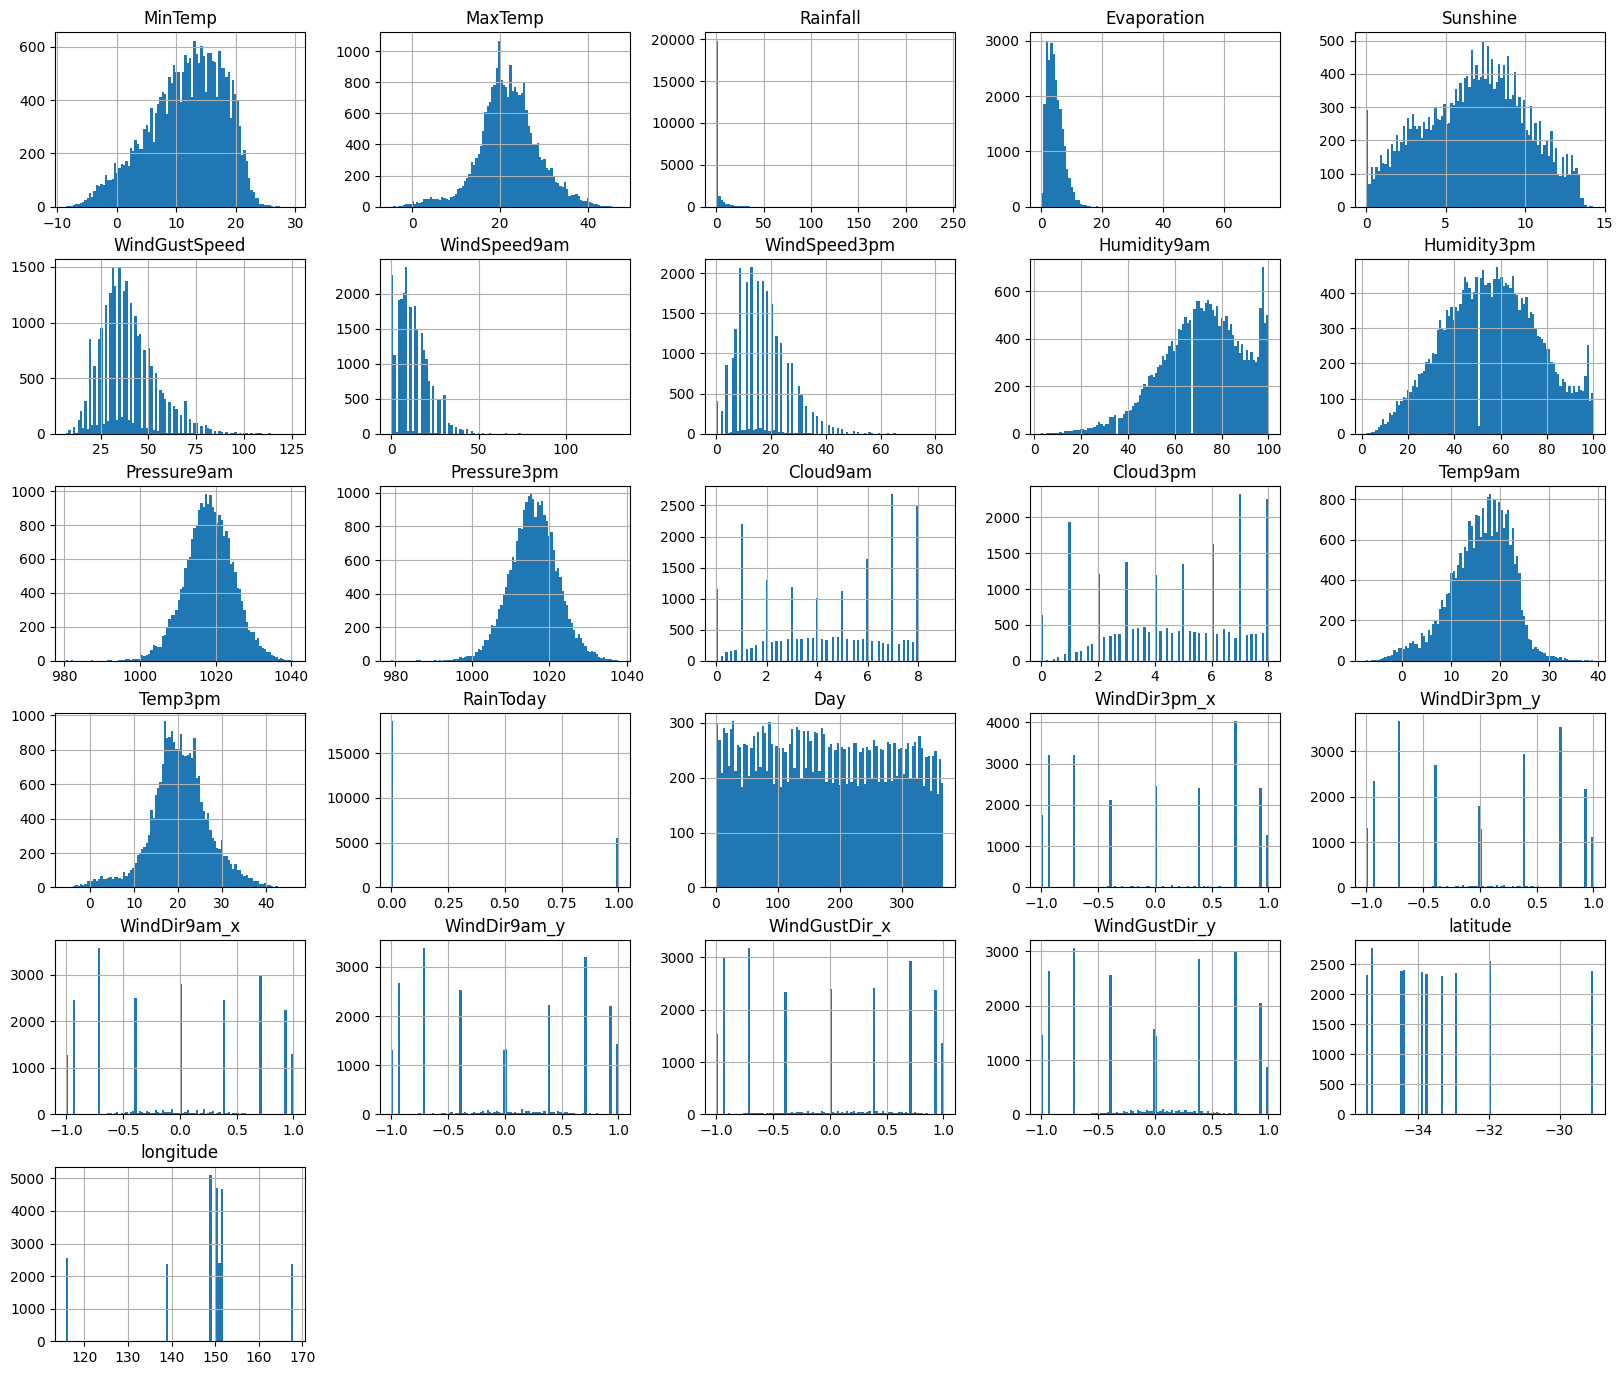

In [91]:
X_train[columns_sin_anios].hist(figsize= (20,17), bins=100)

plt.show()


## Estandarizado

In [92]:
scaler: StandardScaler = StandardScaler()

In [93]:
# Ajustar y transformar el conjunto de entrenamiento
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)


## Matriz de correlación

In [94]:
corr_matrix = X_train[columns_sin_anios].corr()

# Crear un mapa de calor utilizando Plotly
fig = px.imshow(corr_matrix, 
                text_auto=True,  # Muestra los valores de correlación en las celdas
                color_continuous_scale='Viridis',  # Cambia la escala de colores
                title='Matriz de Correlación',  # Título del gráfico
                labels=dict(x='Variables', y='Variables'),  # Etiquetas para los ejes
                width=1200,  # Ajustar el ancho de la figura
                height=800)

# Mostrar el gráfico
fig.show()

## Analisis de balance

In [95]:
y_train.value_counts()

RainTomorrow
0.0             18561
1.0              5642
Name: count, dtype: int64

In [96]:
fig = px.pie(y_train, names='RainTomorrow', title='Balanceo de y_train')
fig.update_layout(bargap=0.5)
fig.show()

In [97]:
#oversampler: RandomOverSampler = RandomOverSampler(random_state=42)

In [98]:
#X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [99]:
# fig = px.histogram(y_train_resampled, title='Balanceo de y_train_resampled después de Oversampling', barmode='overlay', text_auto=True)
# fig.update_layout(bargap=0.5)
# fig.show()

In [100]:
numerical_float_columns: list[str] = X_train.select_dtypes(include=[np.number, 'float']).columns.to_list()

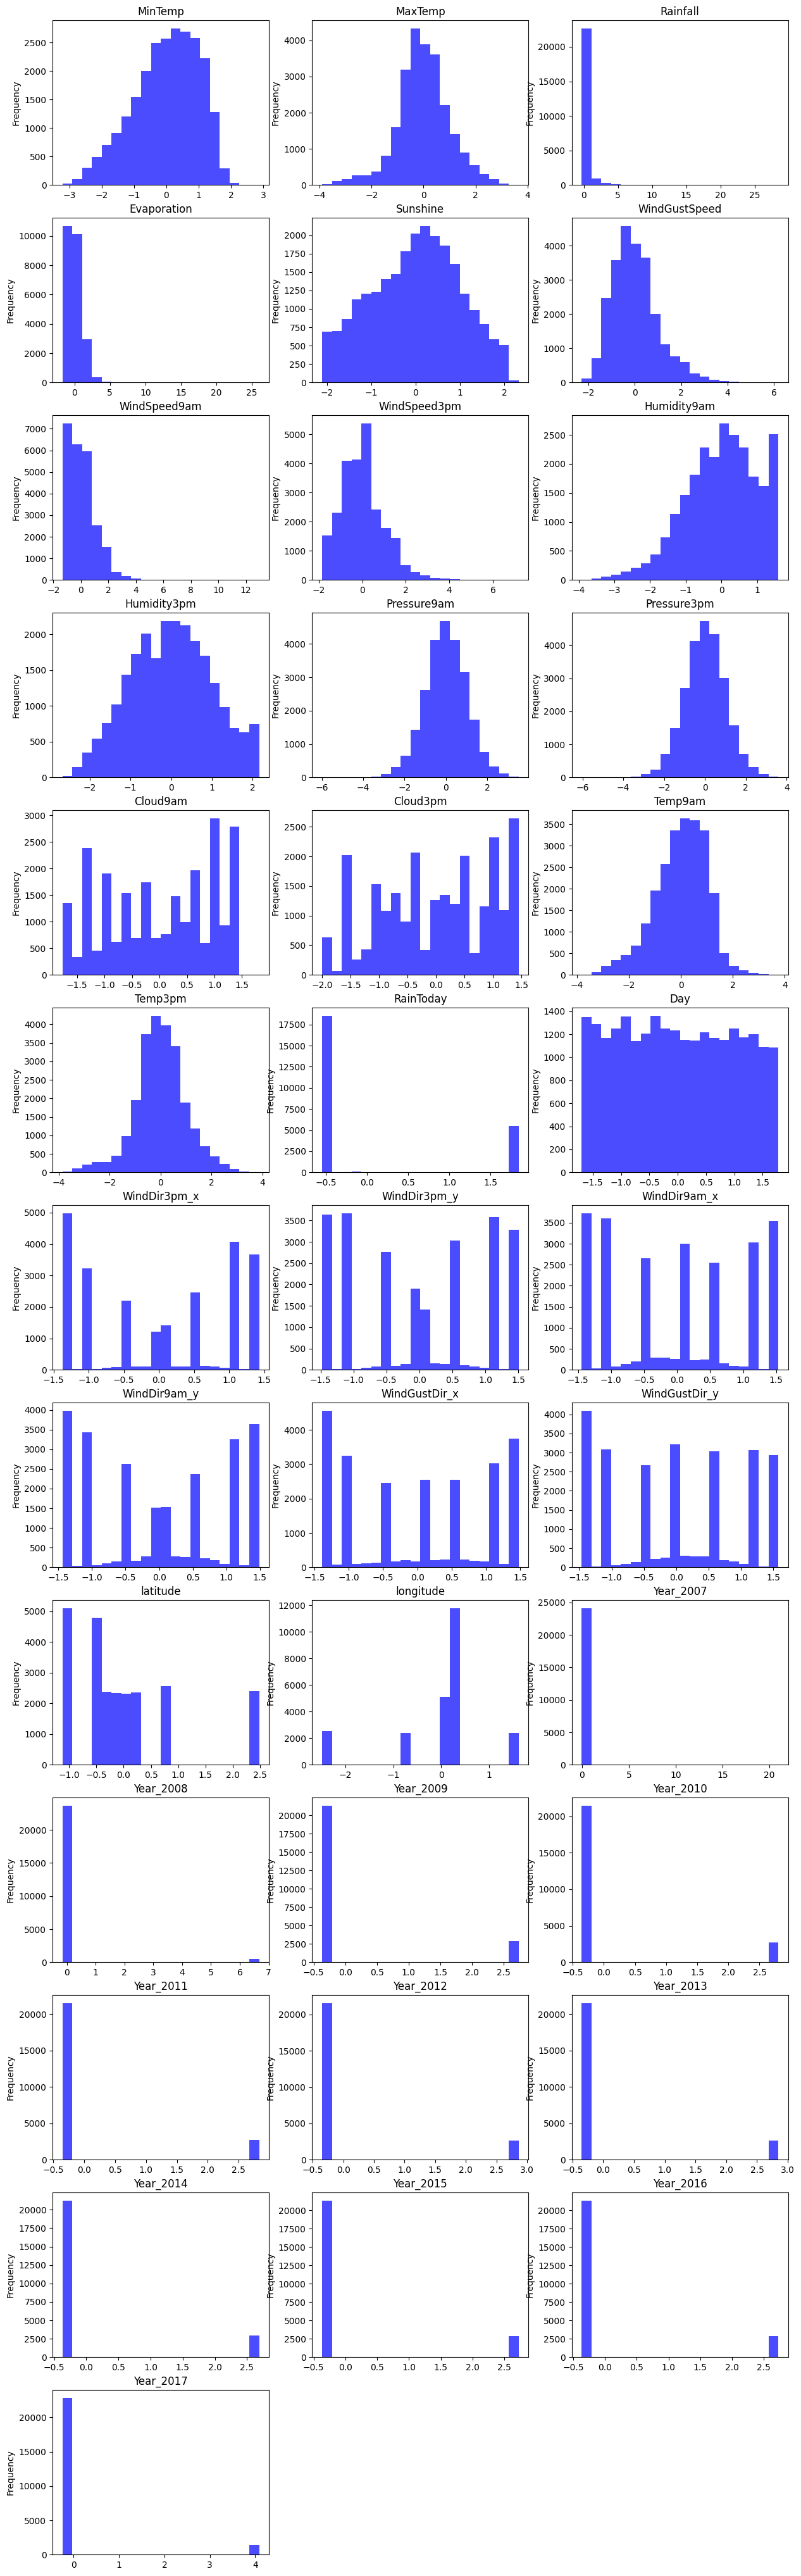

In [101]:
num_columns = 3  # Number of columns per row
num_rows = (len(numerical_float_columns) + num_columns - 1) // num_columns  # Calculate required rows

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 4 * num_rows))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot histograms for each numerical column
for ax, col in zip(axes, numerical_float_columns):
    ax.hist(X_train[col], bins=20, color='blue', alpha=0.7)
    ax.set_title(f'{col}')
    #ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Hide any unused subplots
for i in range(len(numerical_float_columns), len(axes)):
    fig.delaxes(axes[i])

In [102]:
"""
k_values = [1, 3, 5, 7, 9, 11]

# Create subplots for each k value
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 3))

# Train and visualize the models with varying k values
for i, k in enumerate(k_values):
    # Create KNN model
    knn = KNNImputer(n_neighbors=k)

    # Train the model
    knn.fit(X_train[numerical_float_columns], y_train)

    # Make predictions
    y_pred = knn.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Plot decision boundary
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    axes[i].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot the training points
    axes[i].scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                    edgecolors='k', cmap=plt.cm.Paired)

    # Plot the testing points
    axes[i].scatter(X_test[:, 0], X_test[:, 1], c=y_test,
                    marker='x', edgecolors='k', cmap=plt.cm.Paired)

    # Set plot labels and title
    axes[i].set_title(f'k={k}, Accuracy={accuracy:.2f}')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')

plt.show()

"""


"\nk_values = [1, 3, 5, 7, 9, 11]\n\n# Create subplots for each k value\nfig, axes = plt.subplots(1, len(k_values), figsize=(15, 3))\n\n# Train and visualize the models with varying k values\nfor i, k in enumerate(k_values):\n    # Create KNN model\n    knn = KNNImputer(n_neighbors=k)\n\n    # Train the model\n    knn.fit(X_train[numerical_float_columns], y_train)\n\n    # Make predictions\n    y_pred = knn.predict(X_test)\n\n    # Calculate accuracy\n    accuracy = accuracy_score(y_test, y_pred)\n\n    # Plot decision boundary\n    h = 0.02  # Step size in the mesh\n    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1\n    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1\n    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),\n                         np.arange(y_min, y_max, h))\n    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])\n    Z = Z.reshape(xx.shape)\n\n    # Plot the decision boundary\n    axes[i].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)\n\n    # Plot the traini


## Implementación de modelos

Dado que el dataset se encuentra altamente desbalanceado, se descarta el uso de Accuracy como metrica.

Por lo que analizará el modelo en base a Precision, recall, F1

En una primera instancia, se analiza el modelo de regresión logistica 


### Regresión logística sin balance

In [109]:
clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
clf_base.fit(X_train, y_train)
  

#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=['positivo', 'negativo'], yticklabels=['positivo', 'negativo'], annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))
 
pred_y = clf_base.predict(X_test)

#mostrar_resultados(y_test, pred_y)

In [ ]:
conf_matrix = confusion_matrix(y_test, pred_y)
plt.figure(figsize=(12, 12))

In [112]:
print (classification_report(y_test, pred_y))

ValueError: Input y_true contains NaN.